In [3]:
import numpy as np
from numpy.random import default_rng

from gpcam import GPOptimizer

import torch
from torch import nn

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import os
import csv

from scipy.stats import entropy

import random

# Import Data

In [4]:
energy_data_total = np.load("/data/Dataset 1/energy.npy")
cycle_number_total = np.load("/data/Dataset 1/cycle.npy")


# use slicing to select every other column and all rows
energy_data = energy_data_total[:, ::2]
cycle_number = cycle_number_total[::2]

num_of_datasets = len(energy_data[:,0])

label_size = 30
plt.figure(figsize = (20,10))
for i in range(len(energy_data)): plt.scatter(cycle_number,energy_data[i]) 

plt.tick_params(axis='both', which='major', labelsize=label_size) # Set the font size of the tick labels on the x and y axes
plt.xlabel("Cycle Number",fontsize=label_size) 
plt.ylabel("Energy",fontsize=label_size)
plt.show()


# Creating the cycle_data array with the same shape of energy_data, where all rows have the same values as cycle_number_range. This results in 1 row repeated 22 times.
#cycle_data = np.full_like(energy_data, cycle_number_range)

print("max y: ", np.max(energy_data))

max y:  363.5404228825251


# Creating the Subfolder in Results

In [1]:
# Specify the path for the new folder
new_folder_path = f"/results/Dataset 1 Figures/Training NN/"

# Create the folder
os.makedirs(new_folder_path, exist_ok=True)


NameError: name 'os' is not defined

# Deep Kernel Learning

In [5]:
# All remaining code asssumes that the NN architecture is made up of two hidden layers and same number of nodes
# If other architectures are used, the indices of the hyperparameters and their boudsn need to be changed accordingly
# Number of nodes can be varied as the user prefer

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.nodes_num = 5

        # Inputs to hidden layer linear transformation
        self.layer1 = nn.Linear(1, self.nodes_num)
        self.layer2 = nn.Linear(self.nodes_num, self.nodes_num)
        self.layer3 = nn.Linear(self.nodes_num, 1)

    def forward(self, x):
        # Pass the input tensor through each of our operations
        #print(x)
        x = torch.Tensor(x)
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        x = torch.nn.functional.relu(self.layer3(x))
        return x.detach().numpy()

    def set_weights(self,w1,w2,w3):
      with torch.no_grad():
        self.layer1.weight = nn.Parameter(torch.from_numpy(w1).float())
        self.layer2.weight = nn.Parameter(torch.from_numpy(w2).float())
        self.layer3.weight = nn.Parameter(torch.from_numpy(w3).float())

    def set_biases(self,b1,b2,b3):
      with torch.no_grad():
        self.layer1.bias = nn.Parameter(torch.from_numpy(b1).float())
        self.layer2.bias = nn.Parameter(torch.from_numpy(b2).float())
        self.layer3.bias = nn.Parameter(torch.from_numpy(b3).float())

    def get_weights(self):
        return self.layer1.weight, self.layer2.weight, self.layer3.weight
    def get_biases(self):
        return self.layer1.bias, self.layer2.bias, self.layer3.bias

n = Network()


# Defining GP Components

In [6]:
# For the squared Exponential Function
def get_distance_matrix(x1,x2):
    d = np.zeros((len(x1),len(x2)))
    for i in range(x1.shape[1]):
        d += (x1[:,i].reshape(-1, 1) - x2[:,i])**2
    return np.sqrt(d)

# For the Noise
def s(x, my_slope, my_pow, my_intercept):
    o = my_slope * x**my_pow + my_intercept
    return o

def my_noise(x,hps,obj):

    total_num_of_NN_hps = obj.args[1]

    my_slope     = hps[total_num_of_NN_hps+1]
    my_pow       = hps[total_num_of_NN_hps+2]
    my_intercept = hps[total_num_of_NN_hps+3]

    my_s = s(x,my_slope,my_pow,my_intercept)

    noise = np.diag(my_s[:,0])
    
    return noise

# Kernel Function
def kernel_nn(x1,x2,hps,obj):

    nodes_num           = obj.args[0]
    total_num_of_NN_hps = obj.args[1]

    # NN
    n.set_weights(hps[0:nodes_num].reshape(nodes_num,1),
                  hps[nodes_num:nodes_num**2+nodes_num].reshape(nodes_num,nodes_num),
                  hps[nodes_num**2+nodes_num:nodes_num**2+2*nodes_num].reshape(1,nodes_num))

    n.set_biases(hps[nodes_num**2+2*nodes_num:nodes_num**2+3*nodes_num].reshape(nodes_num),
                 hps[nodes_num**2+3*nodes_num:nodes_num**2+4*nodes_num].reshape(nodes_num),
                 np.array([hps[nodes_num**2+4*nodes_num]]))

    x1_nn = n.forward(x1).reshape(-1,1)
    x2_nn = n.forward(x2).reshape(-1,1)
    d = get_distance_matrix(x1_nn,x2_nn)


    # Main Function
    k = hps[total_num_of_NN_hps] * obj.squared_exponential_kernel(d, 50) #100

    return k


################################################################################

# Mean function: Two-Element piecewise function
def mean2(x,hps,obj):

    total_num_of_NN_hps = obj.args[1]

    x0 = hps[total_num_of_NN_hps+4]
    
    m1 = hps[total_num_of_NN_hps+5]
    m2 = hps[total_num_of_NN_hps+6]

    b1  = 360
    b2 = (m1 - m2) * x0 + b1

    x = x[:,0]

    y = np.where(x <= x0, m1*x + b1, m2*x + b2)
                
    return y

# Training the Model

In [7]:
x_pred = np.linspace(0,600,1001).reshape(-1,1)

nodes_num = n.nodes_num

total_num_of_NN_hps = nodes_num**2 + 4*nodes_num + 1     # Depends on the number of layers used
num_of_other_hps = 7                                     # Depends on Kernel, noise and mean functions

NN_weights_initial_hps = np.random.uniform(0, 2,nodes_num**2+2*nodes_num)
NN_biases_initial_hps = np.random.uniform(0, 2,total_num_of_NN_hps-(nodes_num**2+2*nodes_num))


other_init_hps = np.array([3000,                   # Kernel
                          9e-2, 2.09, 0.02,        # Noise
                          250,-0.1,-0.3])         # Mean



init_hyperparameters = np.concatenate([NN_weights_initial_hps,NN_biases_initial_hps,other_init_hps])


trained_hyperparameters = np.array([0.157, 0.149, 0.029, 0.061, 0.016, 0.219, 0.436, 0.148, 0.461, 1.772, 1.945, 0.084,
                         1.743, 0.731, 1.881, 1.342, 1.015, 0.982, 1.795, 0.4,   1.062, 0.753, 1.052, 1.252,
                         1.557, 0.708, 0.149, 1.348, 1.481, 0.568, 0.028, 0.036, 0.107, 0.05,  0.101,
                         1.168, 1.915, 0.184, 0.145, 0.893, 0.377, 1.289, 0.911, 1.971, 0.339, 1.573,
                         1407.5, 0.,    2.164, 1.79, 2.79012e+02, -7.40000e-02, -8.30000e-02])

# Preparing the data
data_size = 10 # How many battery data sets to use for training

# Initializing the Seed
#rng = default_rng()
#numbers = rng.choice(num_of_datasets, data_size, replace=False)
# Making it random all the time
#numbers = random.sample(range(num_of_datasets), data_size)
numbers = np.array([0,1,2,3,4,5,6,7,8,9])
energy = energy_data[numbers]


x_data = np.tile(cycle_number, data_size).reshape(-1, 1)   # repeat cycle 20 times to create x_data
y_data = np.vstack(energy).reshape(-1, 1)                  # stack energy rows to create y_data



print("x data: ", x_data.shape)
print("y data: ", y_data.shape)

    
my_gpNN = GPOptimizer(x_data,y_data,
            #init_hyperparameters = init_hyperparameters,  # we need enough of those for kernel, noise and prior mean functions
            init_hyperparameters = trained_hyperparameters,  # we need enough of those for kernel, noise and prior mean functions
            compute_device='cpu', 
            gp_kernel_function=kernel_nn, 
            gp_kernel_function_grad=None, 
            gp_mean_function=mean2, 
            gp_mean_function_grad=None,
            gp_noise_function=my_noise,
            normalize_y=False,
            sparse_mode=False,
            gp2Scale = False,
            store_inv=False, 
            ram_economy=False, 
            args=np.array([nodes_num,total_num_of_NN_hps]))

# Setting the Optimization Bounds for Hyperparameters
bounds = np.empty((total_num_of_NN_hps + num_of_other_hps,2))

# NN
bounds[0:nodes_num**2+2*nodes_num] = np.array([0.,2.])                      # Weights NN: Define spread and shift in output
bounds[nodes_num**2+2*nodes_num:total_num_of_NN_hps] = np.array([0.,2.])    # Biases of NN: Define shift in output

# Kernel Sq Exp 
bounds[total_num_of_NN_hps] = np.array([500.,7000.])                             # Kernel Variance

# Noise
bounds[total_num_of_NN_hps+1] = np.array([1e-5,15.])                           # Noise Slope
bounds[total_num_of_NN_hps+2] = np.array([1e-3,5.])                            # Noise Power
bounds[total_num_of_NN_hps+3] = np.array([0.,5.])                              # Noise Intercept
# Mean
bounds[total_num_of_NN_hps+4] = np.array([200.,450.])                          # Mean Piecewise Intersection point
bounds[total_num_of_NN_hps+5] = np.array([-1e-1,-6e-2])                        # Mean Slope 1
bounds[total_num_of_NN_hps+6] = np.array([-3e-1,-1e-3])                        # Mean Slope 2



my_gpNN.train(hyperparameter_bounds=bounds,method="global")#,max_iter = 50)#

print("Training is Done")


x data:  (500, 1)
y data:  (500, 1)
Training is Done


In [9]:
#let's make predictions
meanNN = my_gpNN.posterior_mean(x_pred)["f(x)"]
varNN =  my_gpNN.posterior_covariance(x_pred, add_noise=True)["v(x)"]

#and plot the normalized data
#plt.figure(figsize = (16,10))

plt.plot(x_pred,meanNN, color="red", label = "Posterior Mean", linewidth = 4)
plt.fill_between(np.squeeze(x_pred), meanNN - 2. * np.sqrt(varNN), meanNN + 2. * np.sqrt(varNN), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data)
plt.legend()
plt.xlim([0,np.max(x_pred)])
plt.title("Fitted Model")
plt.xlabel("Cycle Number")
plt.ylabel("Energy")
plt.savefig('/results/Dataset 1 Figures/Training NN/GP Fit.png') # saving plot with a unique name 

Text(0.5, 1.0, 'Cycle Number')

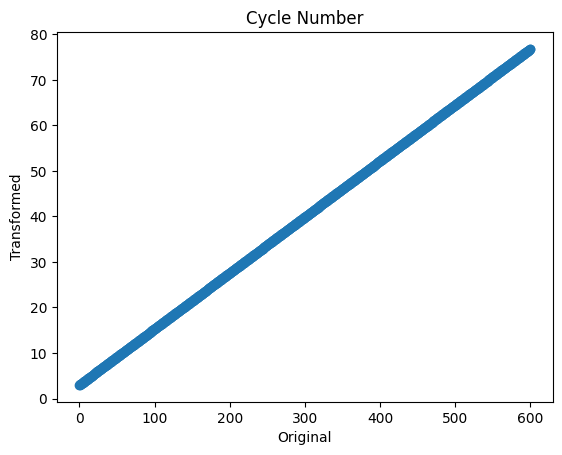

In [82]:
x_pred_nn = n.forward(x_pred)

plt.scatter(x_pred,x_pred_nn)
plt.xlabel("Original")
plt.ylabel("Transformed")
plt.title("Cycle Number")

In [83]:
my_hyperparameter = my_gpNN.hyperparameters

print("NN Weights: ")
print(np.round(my_hyperparameter[0:nodes_num**2+nodes_num*2],3))

print(" ")

print("NN Biases: ")
print(np.round(my_hyperparameter[nodes_num**2+nodes_num*2:total_num_of_NN_hps],3))

print(" ")

print("Sq. Expo Kernel: ")
print(np.round(my_hyperparameter[total_num_of_NN_hps:total_num_of_NN_hps+1],3))

#print("Sq. Expo Kernel lengthscale: ")
#print(np.round(my_hyperparameter[total_num_of_NN_hps+7],3))

print(" ")

print("Noise: ")
print(np.round(my_hyperparameter[total_num_of_NN_hps+1:total_num_of_NN_hps+4],3))

print(" ")

print("Mean: ")
print(np.round(my_hyperparameter[total_num_of_NN_hps+4:total_num_of_NN_hps+7],3))


NN Weights: 
[0.157 0.149 0.029 0.061 0.016 0.219 0.436 0.148 0.461 1.772 1.945 0.084
 1.743 0.731 1.881 1.342 1.015 0.982 1.795 0.4   1.062 0.753 1.052 1.252
 1.557 0.708 0.149 1.348 1.481 0.568 0.028 0.036 0.107 0.05  0.101]
 
NN Biases: 
[1.168 1.915 0.184 0.145 0.893 0.377 1.289 0.911 1.971 0.339 1.573]
 
Sq. Expo Kernel: 
[1407.5]
 
Noise: 
[0.    2.164 1.79 ]
 
Mean: 
[ 2.79012e+02 -7.40000e-02 -8.30000e-02]


Text(0.5, 1.0, 'Trained Prior Mean')

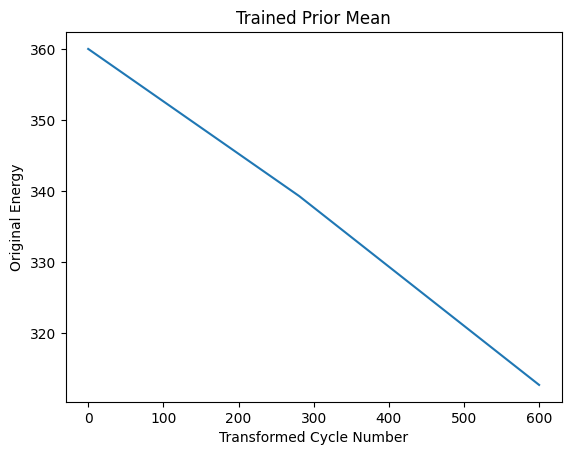

In [87]:
my_prior_mean = mean2(x_pred,my_hyperparameter,my_gpNN)

plt.plot(x_pred,my_prior_mean)
plt.scatter(x_data[0:501],y_data[0:501])
plt.ylabel("Original Energy")
plt.xlabel("Transformed Cycle Number")
plt.title("Trained Prior Mean")

0.000408910962797826
2.164290430105319
1.7902057510110496


Text(0, 0.5, 'Energy Standard Deviation')

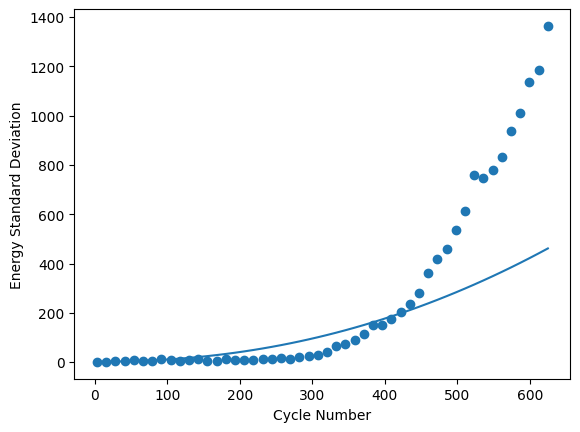

In [86]:
data_varaibility = np.var(energy,axis=0).reshape(-1,1)
data_std = np.sqrt(data_varaibility)


my_slope  = my_hyperparameter[total_num_of_NN_hps+1]
my_pow    = my_hyperparameter[total_num_of_NN_hps+2]
my_offset = my_hyperparameter[total_num_of_NN_hps+3]


print(my_slope)
print(my_pow)
print(my_offset)

predicted_variability =s(cycle_number, my_slope, my_pow, my_offset)

plt.scatter(cycle_number,data_varaibility)
plt.plot(cycle_number,predicted_variability)
plt.xlabel("Cycle Number")
plt.ylabel("Energy Standard Deviation")
#plt.ylim([-10, 50])